In [1]:
%matplotlib inline

/home/cyb/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '



# Feature transformations with ensembles of trees


Transform your features into a higher dimensional, sparse space. Then
train a linear model on these features.

First fit an ensemble of trees (totally random trees, a random
forest, or gradient boosted trees) on the training set. Then each leaf
of each tree in the ensemble is assigned a fixed arbitrary feature
index in a new feature space. These leaf indices are then encoded in a
one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble
and ends up in one leaf per tree. The sample is encoded by setting
feature values for these leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.




# 导入包

In [2]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

# 生成并分割数据

In [19]:
n_estimator = 10
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# 使用TRTE进行特征转换

In [20]:
# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
	random_state=0)
rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

类似于将整个流程封装到pipeline（管道）中，之后只需要调用pipeline就能省去很多工作量，相当于编程技术的偷懒   
[python pipeline原理](http://blog.csdn.net/lanchunhui/article/details/50521648)  
[sklearn pipeline文档](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline)  

无监督进行特征转换：低维特征到高维稀疏空间的转换，然后使用转换后的数据进行分类学习  
[Bagging与随机森林算法原理小结](http://www.bubuko.com/infodetail-1866967.html)  
[sklearn (Total)RandomTreesEmbedding(TRTE)](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding)

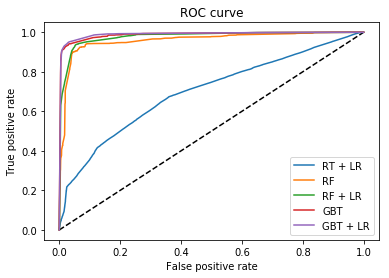

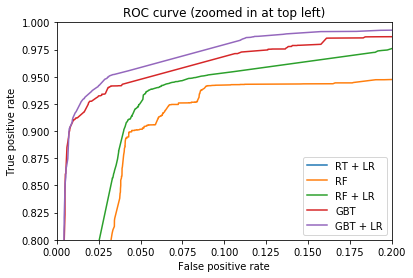

In [21]:
# Author: Tim Head <betatim@gmail.com>
#
# License: BSD 3 clause






# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# pickle保存Python变量

In [37]:
getback = pickle.load(open('./data.txt', 'rb'))

UnpicklingError: invalid load key, '['.

In [38]:
import pickle
value = ['Liu zong is sexy.', 'Liu zong is hot.']
pickle.dump(value, open('C:/Users/sliu/Desktop/tmp.txt', 'wb'))
getback = pickle.load(open('C:/Users/sliu/Desktop/tmp.txt', 'rb'))

# Python2.7中list的Unicode转中文

In [ ]:
# 在Python3.6中语法错误，在Python2.7中运行无误
test = [u'\u679c\u9171', u'\u679c\u9171', u'\u7eb8\u5c3f\u88e4', u'\u679c\u9171', u'\u7eb8\u5c3f\u88e4', u'\u5976\u916a', u'\u7eb8\u5c3f\u88e4']
print(test)
print(str(test).replace('u\'', '\'').decode("unicode-escape"))